In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    # Get the fitted label encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same label encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same label encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_convnext_model(architecture='convnext_tiny', num_classes=4, pretrained=True):
    """Create ConvNeXt model for multi-class classification"""
    if architecture == 'convnext_tiny':
        model = timm.create_model('convnext_tiny', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_small':
        model = timm.create_model('convnext_small', pretrained=pretrained, num_classes=num_classes)
    elif architecture == 'convnext_base':
        model = timm.create_model('convnext_base', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Architecture must be 'convnext_tiny', 'convnext_small', or 'convnext_base'")
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train ConvNeXt Tiny

Training ConvNeXt-Tiny


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:30<00:00,  1.23it/s, Loss=1.8084, Acc=0.2467]


Train Loss: 1.8084 Acc: 0.2467 Macro-F1: 0.2185


Val : 100%|██████████| 10/10 [00:04<00:00,  2.43it/s, Loss=1.4594, Acc=0.3684]


Val Loss: 1.4594 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.37it/s, Loss=1.4274, Acc=0.2188]


Train Loss: 1.4274 Acc: 0.2188 Macro-F1: 0.2020


Val : 100%|██████████| 10/10 [00:01<00:00,  8.26it/s, Loss=1.3545, Acc=0.3684]


Val Loss: 1.3545 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.37it/s, Loss=1.4344, Acc=0.2377]


Train Loss: 1.4344 Acc: 0.2377 Macro-F1: 0.2173


Val : 100%|██████████| 10/10 [00:01<00:00,  8.04it/s, Loss=1.3534, Acc=0.2829]


Val Loss: 1.3534 Acc: 0.2829 Macro-F1: 0.1103

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.37it/s, Loss=1.4205, Acc=0.2607]


Train Loss: 1.4205 Acc: 0.2607 Macro-F1: 0.2175


Val : 100%|██████████| 10/10 [00:01<00:00,  8.03it/s, Loss=1.4508, Acc=0.0724]


Val Loss: 1.4508 Acc: 0.0724 Macro-F1: 0.0337

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.37it/s, Loss=1.4172, Acc=0.2549]


Train Loss: 1.4172 Acc: 0.2549 Macro-F1: 0.2349


Val : 100%|██████████| 10/10 [00:01<00:00,  8.19it/s, Loss=1.4171, Acc=0.2829]


Val Loss: 1.4171 Acc: 0.2829 Macro-F1: 0.1103

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:27<00:00,  1.38it/s, Loss=1.4112, Acc=0.2804]


Train Loss: 1.4112 Acc: 0.2804 Macro-F1: 0.2312


Val : 100%|██████████| 10/10 [00:01<00:00,  8.13it/s, Loss=1.3930, Acc=0.2763]


Val Loss: 1.3930 Acc: 0.2763 Macro-F1: 0.1082
Early stopping triggered after 6 epochs
Training complete in 2m 60s
Best validation macro-F1: 0.1346


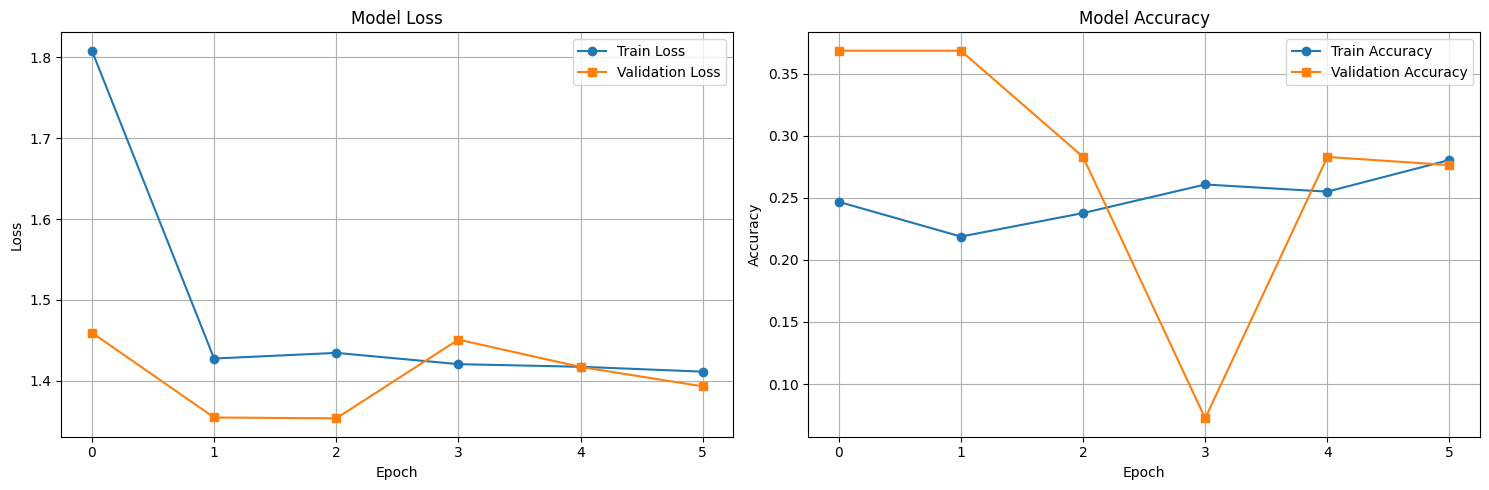

Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.87it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 28.04%
Test Loss: 1.4123

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.28      1.00      0.44        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.28       189
   macro avg       0.07      0.25      0.11       189
weighted avg       0.08      0.28      0.12       189


Confusion Matrix:
[[ 0 74  0  0]
 [ 0 53  0  0]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.4954
Micro-average AUC: 0.4957
HGC AUC: 0.6170
LGC AUC: 0.2581
NST AUC: 0.4667
NTL AUC: 0.6398


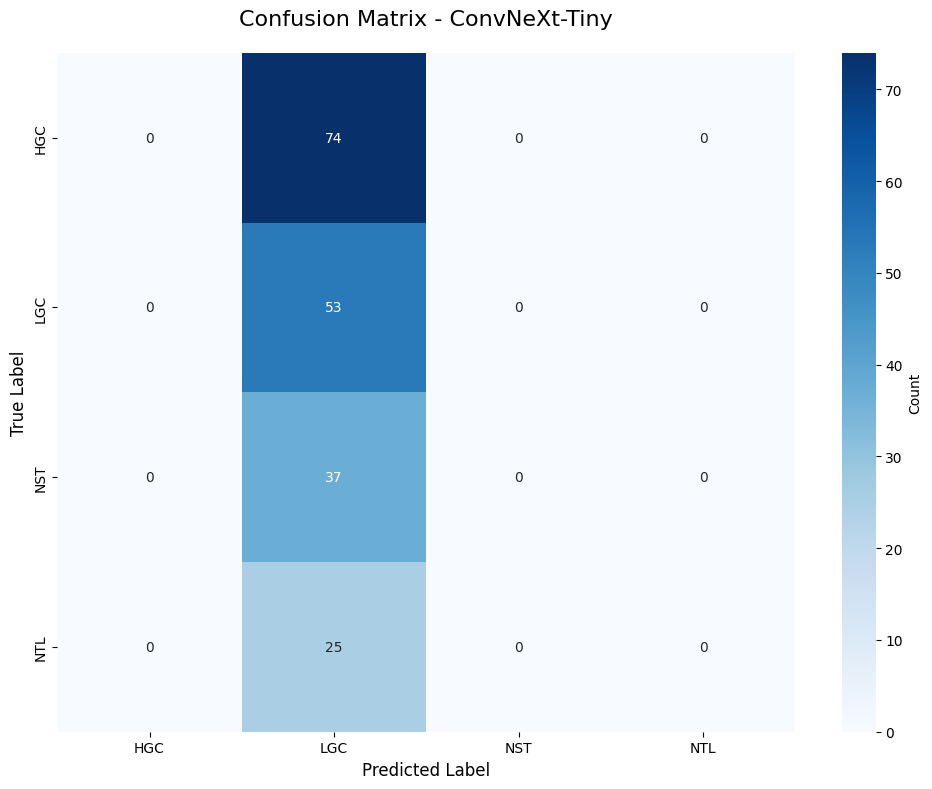

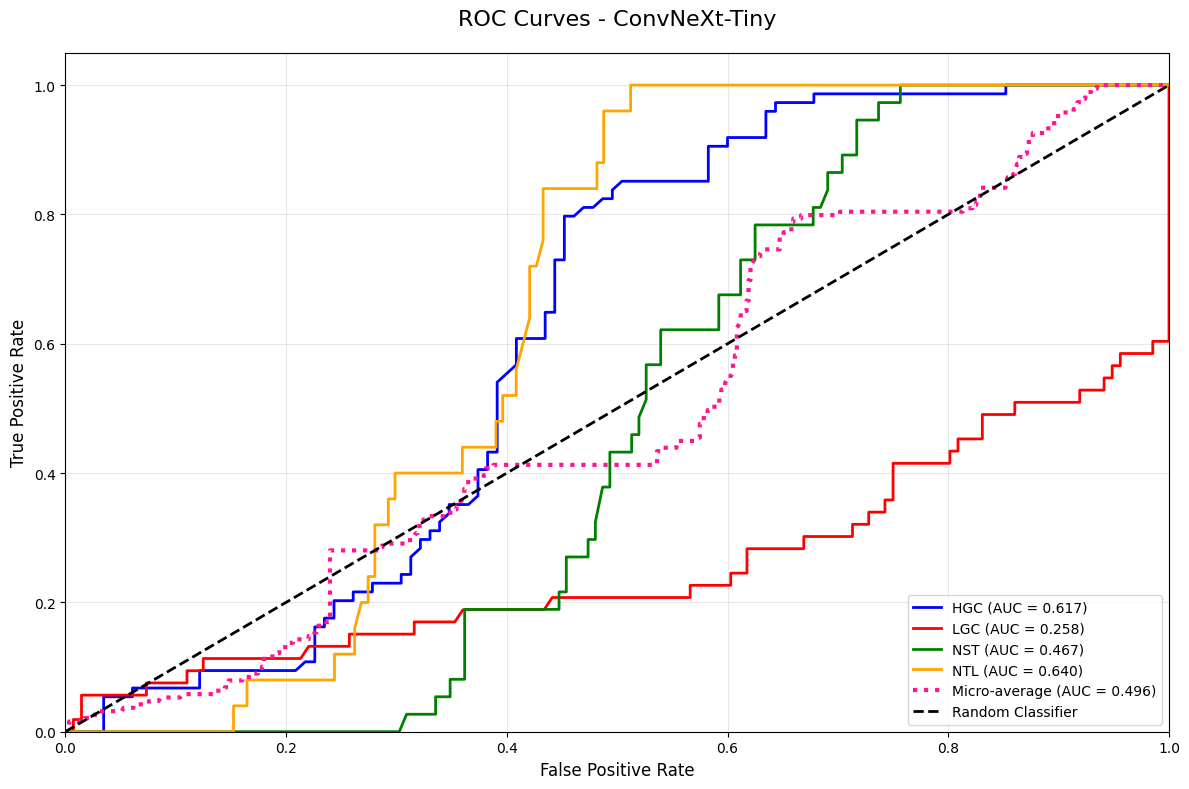


ConvNeXt-Tiny training and evaluation complete!


In [16]:
print("=" * 80)
print("Training ConvNeXt-Tiny")
print("=" * 80)

# Create model
convnext_tiny = create_convnext_model(architecture='convnext_tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_convnext_tiny = ModelTrainer(convnext_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_tiny = trainer_convnext_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Tiny")

# Plot training history
trainer_convnext_tiny.plot_training_history(save_path='convnext_tiny_training_history.png')

# Evaluate model
results_convnext_tiny = trainer_convnext_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_tiny['confusion_matrix'], class_names, 'ConvNeXt-Tiny',
                      save_path='convnext_tiny_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_tiny = plot_roc_curves(results_convnext_tiny['labels'], results_convnext_tiny['probabilities'], class_names, 'ConvNeXt-Tiny',
                                     save_path='convnext_tiny_roc_curves.png')

# Store results
results_convnext_tiny['model_name'] = 'ConvNeXt-Tiny'
results_convnext_tiny['roc_auc'] = roc_auc_convnext_tiny
all_results.append(results_convnext_tiny)

print("\nConvNeXt-Tiny training and evaluation complete!")

## Train ConvNeXt Base

Training ConvNeXt-Base


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:58<00:00,  1.55s/it, Loss=1.5547, Acc=0.2952]


Train Loss: 1.5547 Acc: 0.2952 Macro-F1: 0.2697


Val : 100%|██████████| 10/10 [00:04<00:00,  2.33it/s, Loss=1.3609, Acc=0.3684]


Val Loss: 1.3609 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=1.4256, Acc=0.2360]


Train Loss: 1.4256 Acc: 0.2360 Macro-F1: 0.2103


Val : 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, Loss=1.3589, Acc=0.3684]


Val Loss: 1.3589 Acc: 0.3684 Macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=1.3681, Acc=0.3240]


Train Loss: 1.3681 Acc: 0.3240 Macro-F1: 0.2830


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=1.3295, Acc=0.3224]


Val Loss: 1.3295 Acc: 0.3224 Macro-F1: 0.2607
✓ New best model saved with validation macro-F1: 0.2607

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=1.3031, Acc=0.4095]


Train Loss: 1.3031 Acc: 0.4095 Macro-F1: 0.3438


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=1.1764, Acc=0.4211]


Val Loss: 1.1764 Acc: 0.4211 Macro-F1: 0.3336
✓ New best model saved with validation macro-F1: 0.3336

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:56<00:00,  1.50s/it, Loss=1.1924, Acc=0.4581]


Train Loss: 1.1924 Acc: 0.4581 Macro-F1: 0.4125


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=1.1098, Acc=0.5263]


Val Loss: 1.1098 Acc: 0.5263 Macro-F1: 0.3324

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=1.1066, Acc=0.5666]


Train Loss: 1.1066 Acc: 0.5666 Macro-F1: 0.5160


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=1.0126, Acc=0.6250]


Val Loss: 1.0126 Acc: 0.6250 Macro-F1: 0.5909
✓ New best model saved with validation macro-F1: 0.5909

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.51s/it, Loss=1.0715, Acc=0.5469]


Train Loss: 1.0715 Acc: 0.5469 Macro-F1: 0.5010


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.9504, Acc=0.6250]


Val Loss: 0.9504 Acc: 0.6250 Macro-F1: 0.5751

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.52s/it, Loss=0.8657, Acc=0.6957]


Train Loss: 0.8657 Acc: 0.6957 Macro-F1: 0.6358


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.7733, Acc=0.7533]


Val Loss: 0.7733 Acc: 0.7533 Macro-F1: 0.6968
✓ New best model saved with validation macro-F1: 0.6968

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.51s/it, Loss=0.7820, Acc=0.7410]


Train Loss: 0.7820 Acc: 0.7410 Macro-F1: 0.6794


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.8306, Acc=0.7007]


Val Loss: 0.8306 Acc: 0.7007 Macro-F1: 0.6516

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.51s/it, Loss=0.7456, Acc=0.7262]


Train Loss: 0.7456 Acc: 0.7262 Macro-F1: 0.6756


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.6940, Acc=0.7632]


Val Loss: 0.6940 Acc: 0.7632 Macro-F1: 0.7161
✓ New best model saved with validation macro-F1: 0.7161

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=0.6763, Acc=0.7607]


Train Loss: 0.6763 Acc: 0.7607 Macro-F1: 0.7153


Val : 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, Loss=0.5847, Acc=0.8059]


Val Loss: 0.5847 Acc: 0.8059 Macro-F1: 0.7825
✓ New best model saved with validation macro-F1: 0.7825

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.51s/it, Loss=0.6137, Acc=0.7887]


Train Loss: 0.6137 Acc: 0.7887 Macro-F1: 0.7534


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.5624, Acc=0.7961]


Val Loss: 0.5624 Acc: 0.7961 Macro-F1: 0.7673

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.51s/it, Loss=0.5489, Acc=0.7895]


Train Loss: 0.5489 Acc: 0.7895 Macro-F1: 0.7622


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.4533, Acc=0.8388]


Val Loss: 0.4533 Acc: 0.8388 Macro-F1: 0.8290
✓ New best model saved with validation macro-F1: 0.8290

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.51s/it, Loss=0.5514, Acc=0.8010]


Train Loss: 0.5514 Acc: 0.8010 Macro-F1: 0.7743


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.5055, Acc=0.8092]


Val Loss: 0.5055 Acc: 0.8092 Macro-F1: 0.7952

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=0.4869, Acc=0.8347]


Train Loss: 0.4869 Acc: 0.8347 Macro-F1: 0.8120


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.4792, Acc=0.7862]


Val Loss: 0.4792 Acc: 0.7862 Macro-F1: 0.7433

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=0.4305, Acc=0.8363]


Train Loss: 0.4305 Acc: 0.8363 Macro-F1: 0.8175


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.4662, Acc=0.8059]


Val Loss: 0.4662 Acc: 0.8059 Macro-F1: 0.7676

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=0.4441, Acc=0.8273]


Train Loss: 0.4441 Acc: 0.8273 Macro-F1: 0.8110


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.4642, Acc=0.7961]


Val Loss: 0.4642 Acc: 0.7961 Macro-F1: 0.7586

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:57<00:00,  1.50s/it, Loss=0.4012, Acc=0.8470]


Train Loss: 0.4012 Acc: 0.8470 Macro-F1: 0.8310


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.4708, Acc=0.7928]


Val Loss: 0.4708 Acc: 0.7928 Macro-F1: 0.7578
Early stopping triggered after 18 epochs
Training complete in 18m 5s
Best validation macro-F1: 0.8290


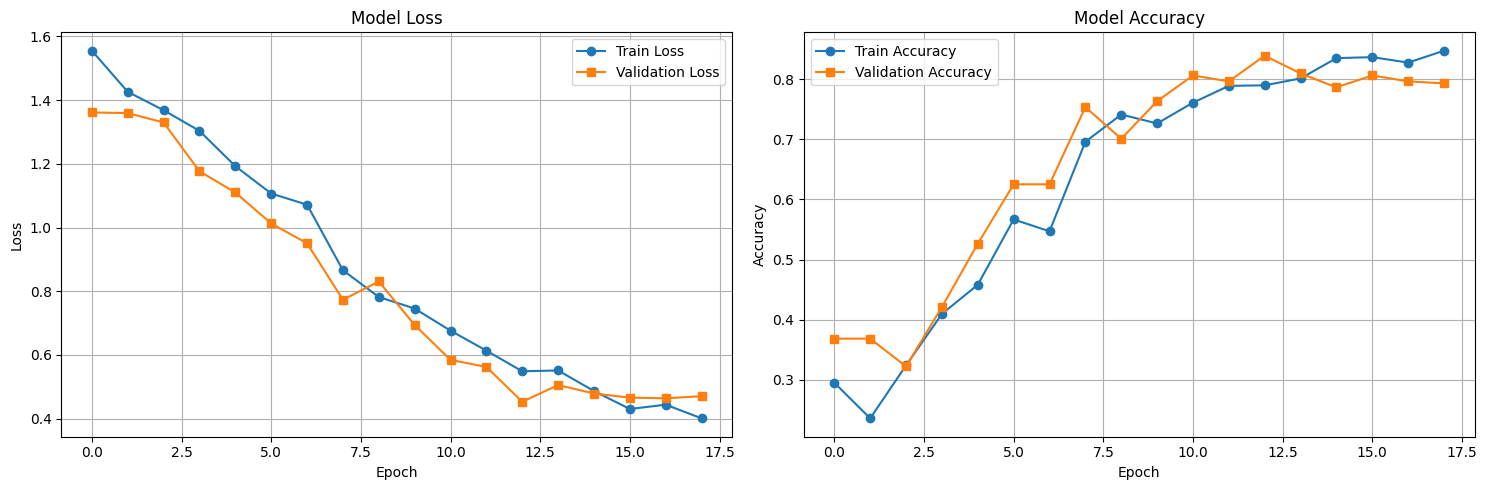

Evaluating on test set...


100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Test Accuracy: 43.39%
Test Loss: 2.0226

Classification Report:
              precision    recall  f1-score   support

         HGC       0.63      0.66      0.64        74
         LGC       1.00      0.15      0.26        53
         NST       0.12      0.05      0.07        37
         NTL       0.27      0.92      0.41        25

    accuracy                           0.43       189
   macro avg       0.50      0.45      0.35       189
weighted avg       0.58      0.43      0.40       189


Confusion Matrix:
[[49  0 13 12]
 [22  8  2 21]
 [ 5  0  2 30]
 [ 2  0  0 23]]

ROC-AUC Scores:
Macro-average AUC: 0.7118
Micro-average AUC: 0.6554
HGC AUC: 0.7229
LGC AUC: 0.7553
NST AUC: 0.6159
NTL AUC: 0.7529


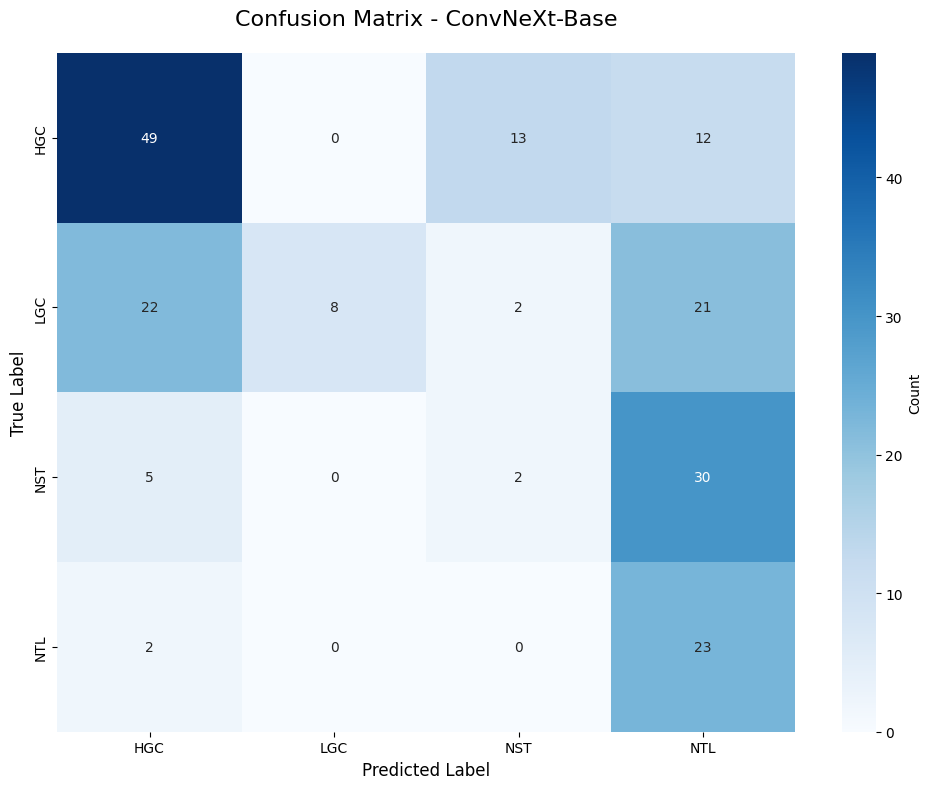

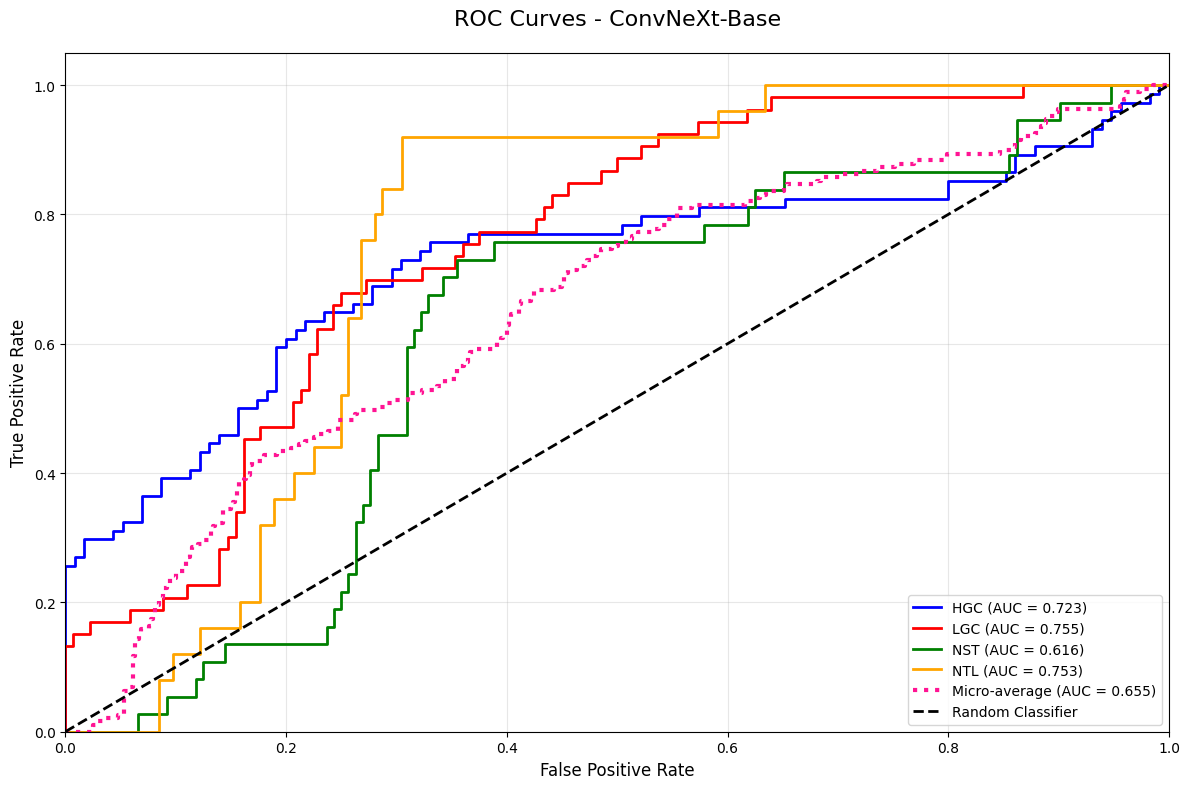


ConvNeXt-Base training and evaluation complete!


In [17]:
print("=" * 80)
print("Training ConvNeXt-Base")
print("=" * 80)

# Create model
convnext_base = create_convnext_model(architecture='convnext_base', num_classes=4, pretrained=True)

# Create trainer
trainer_convnext_base = ModelTrainer(convnext_base, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_base = trainer_convnext_base.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Base")

# Plot training history
trainer_convnext_base.plot_training_history(save_path='convnext_base_training_history.png')

# Evaluate model
results_convnext_base = trainer_convnext_base.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_base['confusion_matrix'], class_names, 'ConvNeXt-Base',
                      save_path='convnext_base_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_base = plot_roc_curves(results_convnext_base['labels'], results_convnext_base['probabilities'], class_names, 'ConvNeXt-Base',
                                     save_path='convnext_base_roc_curves.png')

# Store results
results_convnext_base['model_name'] = 'ConvNeXt-Base'
results_convnext_base['roc_auc'] = roc_auc_convnext_base
all_results.append(results_convnext_base)

print("\nConvNeXt-Base training and evaluation complete!")

## Train ConvNeXt Small

Training ConvNeXt-Small


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.7907, Acc=0.2697]


Train Loss: 1.7907 Acc: 0.2697 Macro-F1: 0.2463


Val : 100%|██████████| 10/10 [00:01<00:00,  5.32it/s, Loss=1.7468, Acc=0.0724]


Val Loss: 1.7468 Acc: 0.0724 Macro-F1: 0.0337
✓ New best model saved with validation macro-F1: 0.0337

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.4635, Acc=0.2294]


Train Loss: 1.4635 Acc: 0.2294 Macro-F1: 0.2175


Val : 100%|██████████| 10/10 [00:01<00:00,  5.35it/s, Loss=1.3565, Acc=0.3684]


Val Loss: 1.3565 Acc: 0.3684 Macro-F1: 0.1346
✓ New best model saved with validation macro-F1: 0.1346

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.4364, Acc=0.2895]


Train Loss: 1.4364 Acc: 0.2895 Macro-F1: 0.2387


Val : 100%|██████████| 10/10 [00:01<00:00,  5.37it/s, Loss=1.3393, Acc=0.3684]


Val Loss: 1.3393 Acc: 0.3684 Macro-F1: 0.1346

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.4207, Acc=0.2681]


Train Loss: 1.4207 Acc: 0.2681 Macro-F1: 0.2248


Val : 100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Loss=1.3817, Acc=0.2763]


Val Loss: 1.3817 Acc: 0.2763 Macro-F1: 0.1082

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.4231, Acc=0.2270]


Train Loss: 1.4231 Acc: 0.2270 Macro-F1: 0.2174


Val : 100%|██████████| 10/10 [00:01<00:00,  5.43it/s, Loss=1.3575, Acc=0.2829]


Val Loss: 1.3575 Acc: 0.2829 Macro-F1: 0.1103

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.4422, Acc=0.2887]


Train Loss: 1.4422 Acc: 0.2887 Macro-F1: 0.2289


Val : 100%|██████████| 10/10 [00:01<00:00,  5.31it/s, Loss=1.4215, Acc=0.0724]


Val Loss: 1.4215 Acc: 0.0724 Macro-F1: 0.0337

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:42<00:00,  1.11s/it, Loss=1.4088, Acc=0.2508]


Train Loss: 1.4088 Acc: 0.2508 Macro-F1: 0.2188


Val : 100%|██████████| 10/10 [00:01<00:00,  5.34it/s, Loss=1.4040, Acc=0.2829]


Val Loss: 1.4040 Acc: 0.2829 Macro-F1: 0.1103
Early stopping triggered after 7 epochs
Training complete in 5m 10s
Best validation macro-F1: 0.1346


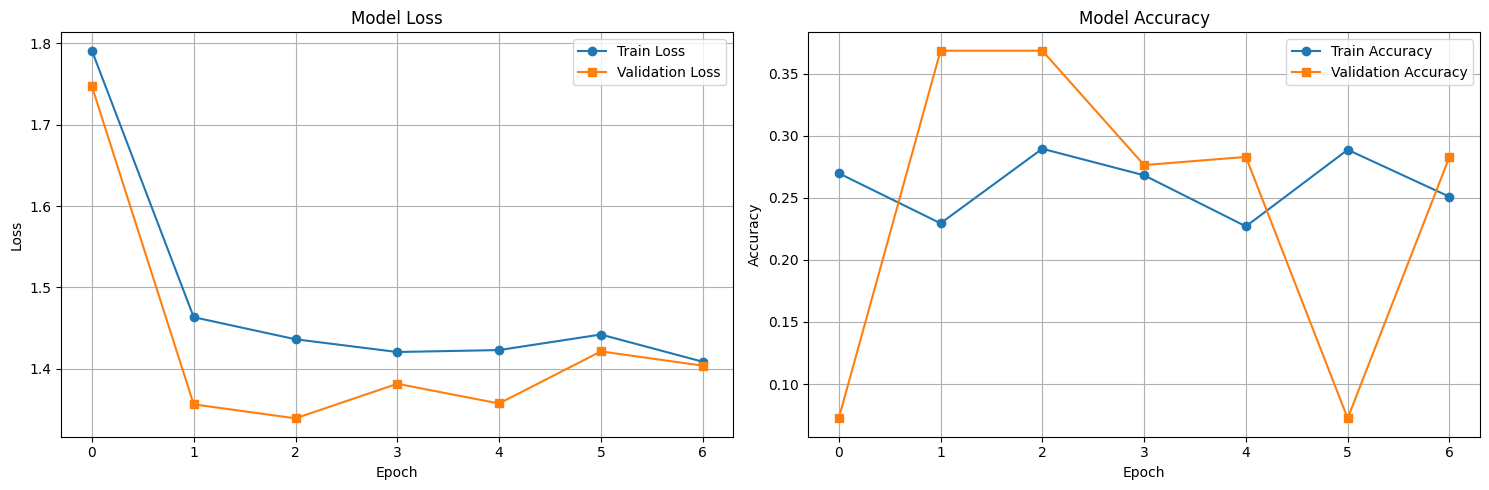

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.52it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 28.04%
Test Loss: 1.4083

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.28      1.00      0.44        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.28       189
   macro avg       0.07      0.25      0.11       189
weighted avg       0.08      0.28      0.12       189


Confusion Matrix:
[[ 0 74  0  0]
 [ 0 53  0  0]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.5993
Micro-average AUC: 0.5579
HGC AUC: 0.3076
LGC AUC: 0.6987
NST AUC: 0.7399
NTL AUC: 0.6510


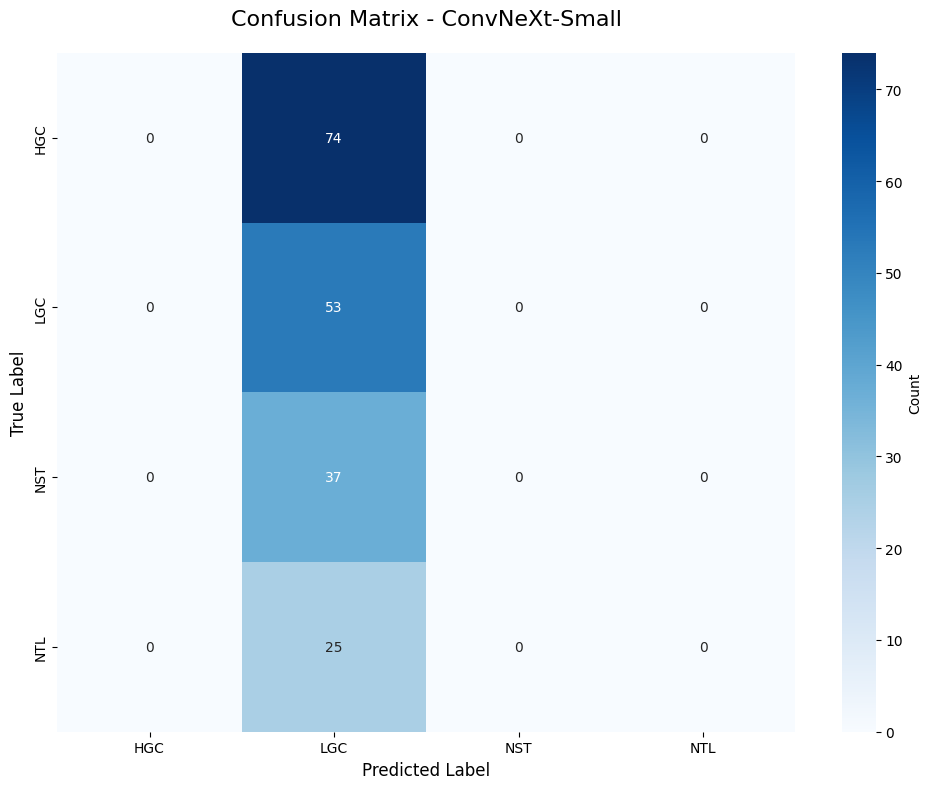

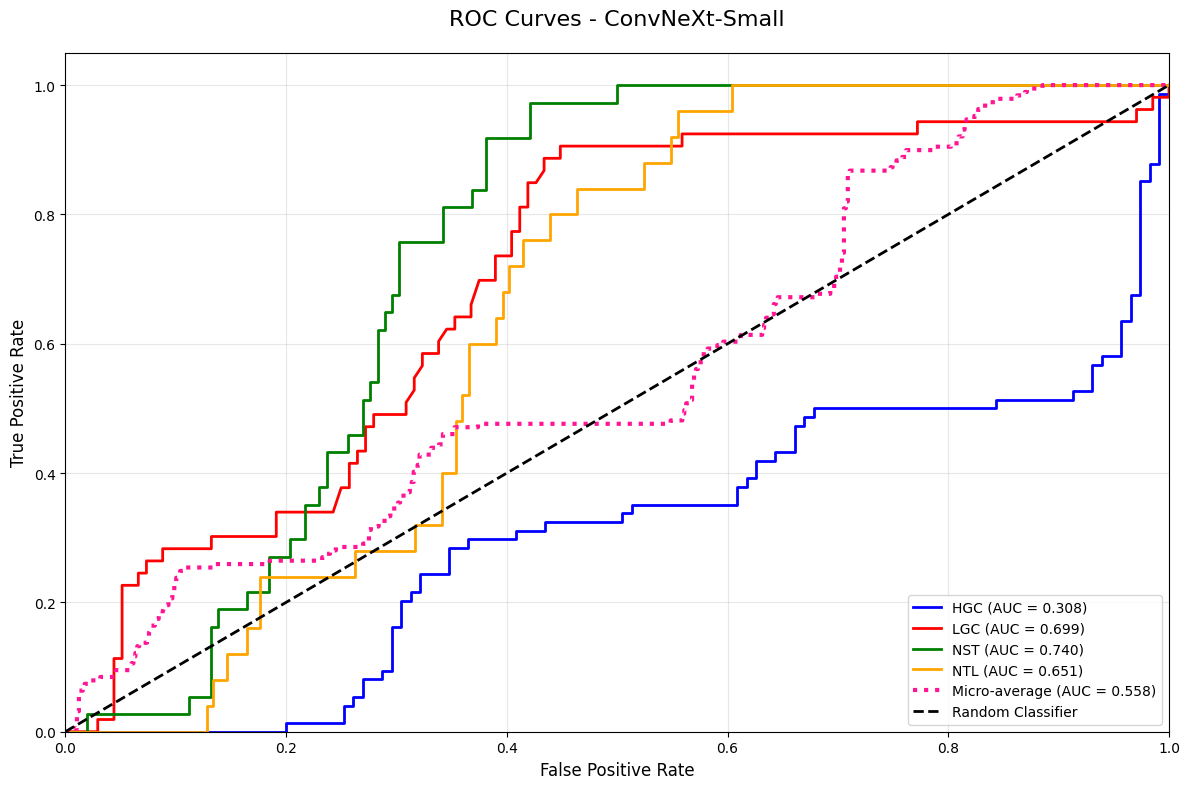


ConvNeXt-Small training and evaluation complete!


In [18]:
print("=" * 80)
print("Training ConvNeXt-Small")
print("=" * 80)

# Create model
convnext_small = create_convnext_model(architecture='convnext_small', num_classes=4, pretrained=True)

# Create trainer
trainer_convnext_small = ModelTrainer(convnext_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_convnext_small = trainer_convnext_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="ConvNeXt-Small")

# Plot training history
trainer_convnext_small.plot_training_history(save_path='convnext_small_training_history.png')

# Evaluate model
results_convnext_small = trainer_convnext_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_convnext_small['confusion_matrix'], class_names, 'ConvNeXt-Small',
                      save_path='convnext_small_confusion_matrix.png')

# Plot ROC curves
roc_auc_convnext_small = plot_roc_curves(results_convnext_small['labels'], results_convnext_small['probabilities'], class_names, 'ConvNeXt-Small',
                                     save_path='convnext_small_roc_curves.png')

# Store results
results_convnext_small['model_name'] = 'ConvNeXt-Small'
results_convnext_small['roc_auc'] = roc_auc_convnext_small
all_results.append(results_convnext_small)

print("\nConvNeXt-Small training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'ConvNeXt_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: ConvNeXt_metrics.csv

Metrics Summary:
            Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   ConvNeXt-Tiny         28.042328      1.412329             0.070106           0.25000      0.109504                0.078637             0.280423         0.122830       0.000000    0.000000  0.000000         74.0       0.280423    1.000000  0.438017         53.0       0.000000    0.000000  0.000000         37.0       0.000000        0.00  0.000000         25.0   0.495378   0.495735  0.616980  0.258116  0.466661  0.639756      0.61698